In [1]:
# Brain Tumor Recognition

# Vorgehen
1. Data preprocessing
2. Convulutional NN aufbauen
3. CNN trainieren
4. Analysieren
5. Falls möglich: Dense Network anhängen

# Data Preprocessing

In [2]:
%pip install tensorflow_datasets

Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

2024-12-19 15:26:14.402654: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-19 15:26:14.440622: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-19 15:26:14.448564: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-19 15:26:14.476855: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 15:26:15.373949: W tensorflow/compiler/tf2

In [4]:
import pandas as pd

In [5]:
import os
import tensorflow as tf

# Basisordner: Daten ist innerhalb des aktuellen Verzeichnisses
base_dir = os.path.join(os.getcwd(), "Daten")
train_dir = os.path.join(base_dir, "Training")
test_dir = os.path.join(base_dir, "Testing")

# Parameter für die Datenverarbeitung
batch_size = 50
img_height = 224
img_width = 224

# Training-Datensatz laden
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),  # Bilder auf einheitliche Größe skalieren
    batch_size=batch_size
)

# Test-Datensatz laden
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Überprüfung der geladenen Daten
print("Trainingsdatenklassen:", train_ds.class_names)
print("Testdatenklassen:", test_ds.class_names)


Found 2846 files belonging to 2 classes.


2024-12-19 15:26:17.571822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13294 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:a5:00.0, compute capability: 8.6


Found 1310 files belonging to 2 classes.
Trainingsdatenklassen: ['No_Tumor', 'Tumor']
Testdatenklassen: ['No_Tumor', 'Tumor']


In [18]:
# Funktion, um die Anzahl der Bilder pro Klasse zu zählen
def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):  # Nur Ordner (Klassen) berücksichtigen
            num_images = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
            class_counts[class_name] = num_images
    return class_counts

# Zähle Bilder im Trainings- und Testordner
train_class_counts = count_images_per_class(train_dir)
test_class_counts = count_images_per_class(test_dir)

# Ausgabe der Ergebnisse
print("Anzahl der Bilder pro Klasse (Training):")
for class_name, count in train_class_counts.items():
    print(f"  {class_name}: {count}")

print("\nAnzahl der Bilder pro Klasse (Testing):")
for class_name, count in test_class_counts.items():
    print(f"  {class_name}: {count}")


Anzahl der Bilder pro Klasse (Training):
  Tumor: 1496
  .ipynb_checkpoints: 0
  No_Tumor: 1350

Anzahl der Bilder pro Klasse (Testing):
  Tumor: 905
  .ipynb_checkpoints: 0
  No_Tumor: 405


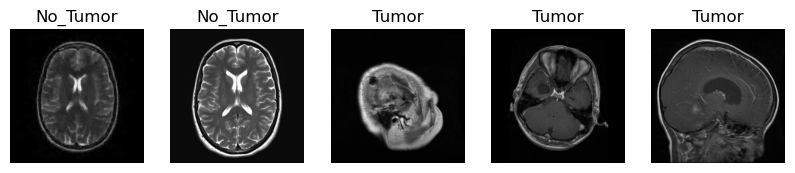

In [20]:
import matplotlib.pyplot as plt

# Anzahl der Bilder, die angezeigt werden sollen
num_images = 5

# Hole eine kleine Stichprobe von Bildern und Labels
image_batch, label_batch = next(iter(train_ds))

# Anzeigen der Bilder und ihrer Klassen
plt.figure(figsize=(10, 10))

for i in range(num_images):
    ax = plt.subplot(1, num_images, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[label_batch[i].numpy()])
    plt.axis("off")

plt.show()


In [15]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Modell erstellen
model = models.Sequential([
    # Erstes Convolutional Layer mit Max-Pooling
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normierung der Pixelwerte
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Zweites Convolutional Layer mit Max-Pooling
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Drittes Convolutional Layer mit Max-Pooling
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Flatten und Dense Layer
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(train_ds.class_names), activation='softmax')  # Anzahl der Klassen (Tumor/No_Tumor)
])

# Modell zusammenfassen
model.summary()

# EarlyStopping Callback definieren
early_stopping = EarlyStopping(monitor='val_loss',  # Überwachen des Validation Loss
                               patience=5,         # Geduld (wie viele Epochen ohne Verbesserung)
                               restore_best_weights=True)  # Bestes Modell wird zurückgegeben

# Modell kompilieren
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Modell trainieren mit EarlyStopping Callback
history = model.fit(
    train_ds,
    epochs=20,  # Anzahl der Epochen
    validation_data=test_ds,
    callbacks=[early_stopping]  # Callback hinzufügen
)

/opt/conda/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,277,826 (84.98 MB)

 Trainable params: 22,277,826 (84.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 19s 255ms/step - accuracy: 0.6836 - loss: 0.5753 - val_accuracy: 0.7618 - val_loss: 0.5268
Epoch 2/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9198 - loss: 0.2290 - val_accuracy: 0.8550 - val_loss: 0.3604
Epoch 3/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 125ms/step - accuracy: 0.9590 - loss: 0.1285 - val_accuracy: 0.8733 - val_loss: 0.3429
Epoch 4/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9701 - loss: 0.0971 - val_accuracy: 0.8802 - val_loss: 0.3139
Epoch 5/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - accuracy: 0.9798 - loss: 0.0746 - val_accuracy: 0.9015 - val_loss: 0.3155
Epoch 6/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 9s 155ms/step - accuracy: 0.9751 - loss: 0.0756 - val_accuracy: 0.9084 - val_loss: 0.3006
Epoch 7/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9806 - loss: 0.0629 - val_accuracy: 0.9084 - val_loss: 0.2979
Epoch 8/20
57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 129ms/step - accuracy: 0.9848 - loss: 0.0490 - val_accuracy: 0

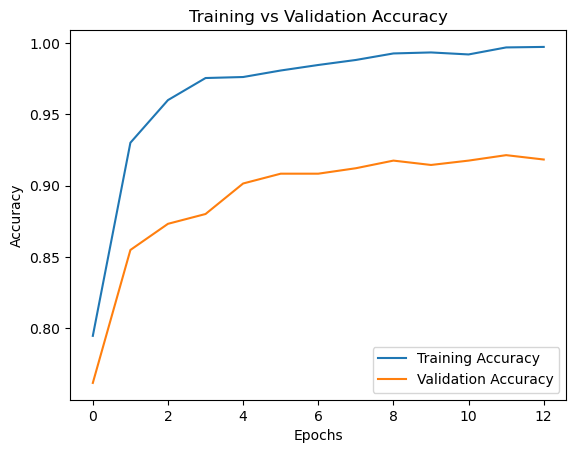

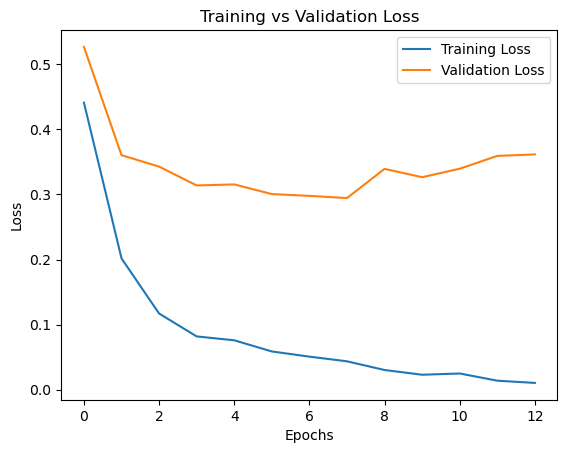

In [16]:
import matplotlib.pyplot as plt

# Training und Validierung Genauigkeit plotten
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training und Validierung Verlust plotten
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


2024-12-19 15:32:28.232903: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step


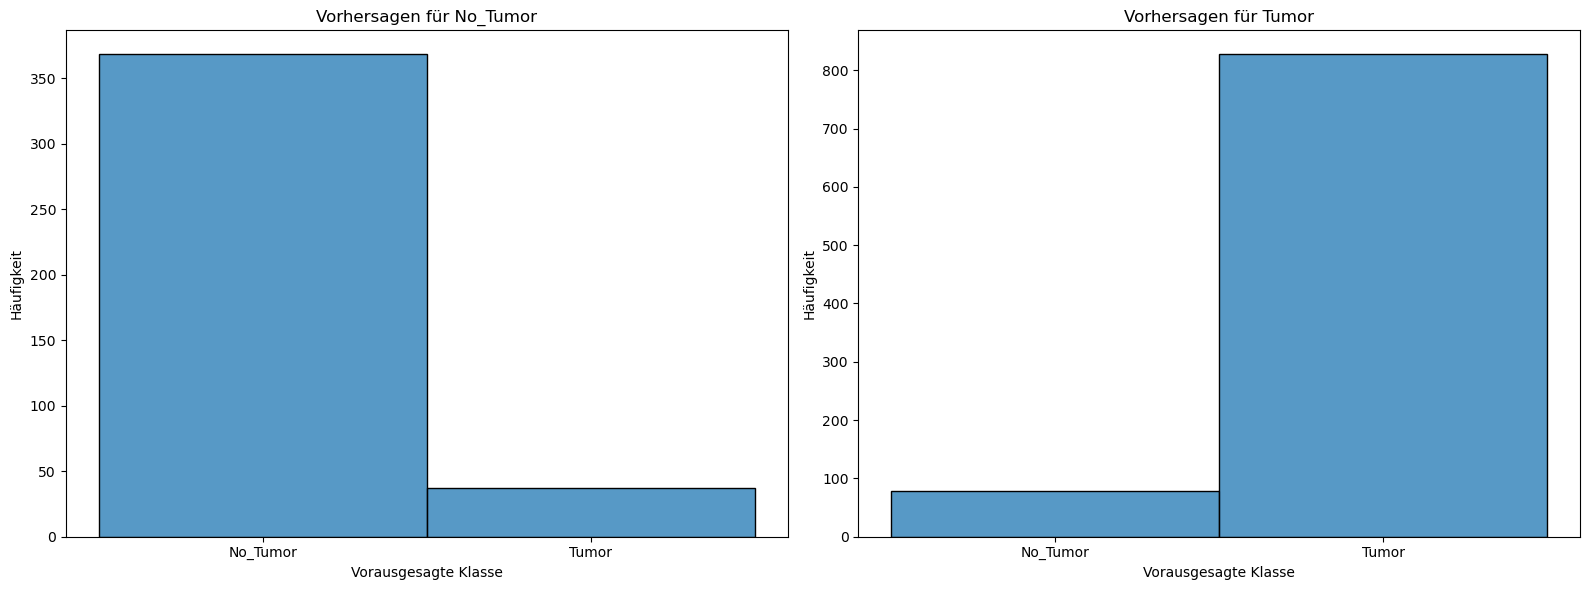

In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Vorbereitung der Testdaten für Vorhersagen
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = tf.concat(test_images, axis=0)
test_labels = tf.concat(test_labels, axis=0)

# Vorhersagen machen
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# DataFrame mit wahren Labels und vorhergesagten Labels für Visualisierung
results_df = pd.DataFrame({
    'True Label': test_labels.numpy(),
    'Predicted Label': predicted_labels
})

# Visualisierung der Häufigkeit der Vorhersagen für jedes wahre Label
plt.figure(figsize=(16, 6))
for i in range(len(train_ds.class_names)):  # Wir haben 2 Klassen: 'Tumor' und 'No_Tumor'
    plt.subplot(1, 2, i + 1)  # 1 Reihe, 2 Spalten (da wir 2 Klassen haben)
    sns.histplot(results_df[results_df['True Label'] == i]['Predicted Label'], bins=np.arange(3) - 0.5, kde=False)
    plt.title(f'Vorhersagen für {train_ds.class_names[i]}')
    plt.xlabel('Vorausgesagte Klasse')
    plt.ylabel('Häufigkeit')
    plt.xticks([0, 1], labels=train_ds.class_names)

plt.tight_layout()
plt.show()


# Modell 2

In [25]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers, models, regularizers

# Modell erstellen
model = models.Sequential([
    # Erstes Convolutional Layer mit Max-Pooling
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),  # Normierung der Pixelwerte
    layers.Conv2D(32, (3, 3), activation='relu',
                 kernel_regularizer=regularizers.L2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Zweites Convolutional Layer mit Max-Pooling
    layers.Conv2D(64, (3, 3), activation='relu',
                 kernel_regularizer=regularizers.L2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Drittes Convolutional Layer mit Max-Pooling
    layers.Conv2D(128, (3, 3), activation='relu',
                 kernel_regularizer=regularizers.L2(0.01)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    
    # Flatten und Dense Layer
    layers.Flatten(),
    layers.Dense(256, activation='relu',
                kernel_regularizer=regularizers.L2(0.01)),
    layers.Dense(128, activation='relu',
                kernel_regularizer=regularizers.L2(0.01)),
    layers.Dropout(0.2),
    layers.Dense(len(train_ds.class_names), activation='softmax')  # Anzahl der Klassen (Tumor/No_Tumor)
])

# Modell zusammenfassen
model.summary()

# EarlyStopping Callback definieren
early_stopping = EarlyStopping(monitor='val_loss',  # Überwachen des Validation Loss
                               patience=5,         # Geduld (wie viele Epochen ohne Verbesserung)
                               restore_best_weights=True)  # Bestes Modell wird zurückgegeben

# Modell kompilieren
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Modell trainieren mit EarlyStopping Callback
history = model.fit(
    train_ds,
    epochs=50,  # Anzahl der Epochen
    validation_data=test_ds,
    callbacks=[early_stopping]  # Callback hinzufügen
)

/opt/conda/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_6 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,277,826 (84.98 MB)

 Trainable params: 22,277,826 (84.98 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 17s 221ms/step - accuracy: 0.6628 - loss: 7.3440 - val_accuracy: 0.7382 - val_loss: 4.4760
Epoch 2/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.8987 - loss: 3.8360 - val_accuracy: 0.8000 - val_loss: 3.2748
Epoch 3/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9213 - loss: 2.9346 - val_accuracy: 0.8153 - val_loss: 2.8645
Epoch 4/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9526 - loss: 2.4604 - val_accuracy: 0.8611 - val_loss: 2.4287
Epoch 5/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9690 - loss: 2.1369 - val_accuracy: 0.8557 - val_loss: 2.1967
Epoch 6/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 112ms/step - accuracy: 0.9707 - loss: 1.8824 - val_accuracy: 0.8588 - val_loss: 2.0096
Epoch 7/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9694 - loss: 1.6874 - val_accuracy: 0.8718 - val_loss: 1.8093
Epoch 8/50
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 113ms/step - accuracy: 0.9795 - loss: 1.4994 - val_accuracy: 0

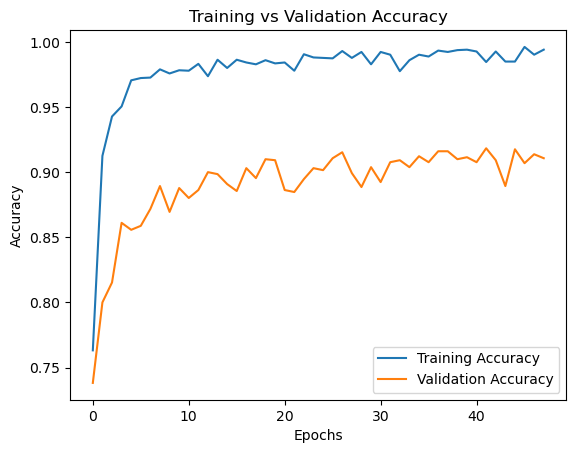

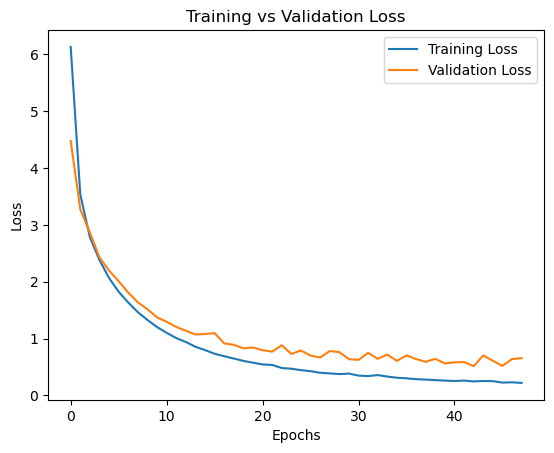

In [26]:
import matplotlib.pyplot as plt

# Training und Validierung Genauigkeit plotten
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Training und Validierung Verlust plotten
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step


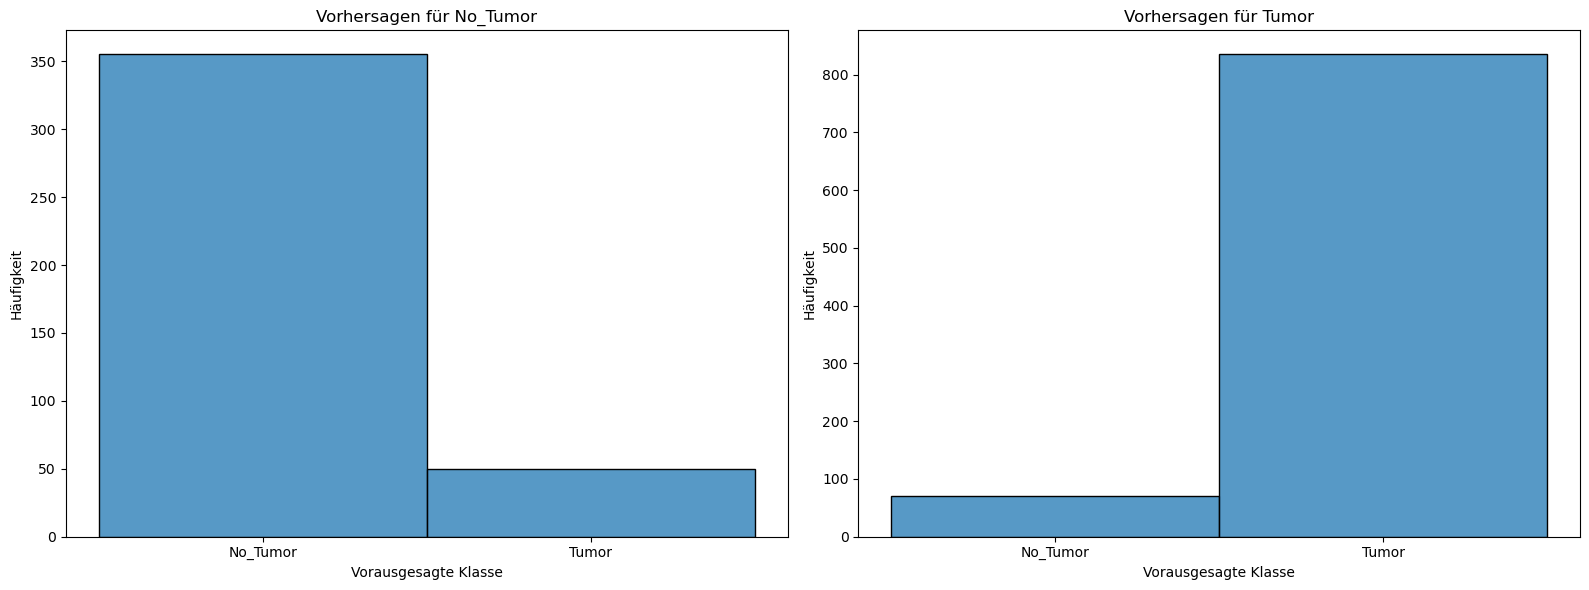

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Vorbereitung der Testdaten für Vorhersagen
test_images = []
test_labels = []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = tf.concat(test_images, axis=0)
test_labels = tf.concat(test_labels, axis=0)

# Vorhersagen machen
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# DataFrame mit wahren Labels und vorhergesagten Labels für Visualisierung
results_df = pd.DataFrame({
    'True Label': test_labels.numpy(),
    'Predicted Label': predicted_labels
})

# Visualisierung der Häufigkeit der Vorhersagen für jedes wahre Label
plt.figure(figsize=(16, 6))
for i in range(len(train_ds.class_names)):  # Wir haben 2 Klassen: 'Tumor' und 'No_Tumor'
    plt.subplot(1, 2, i + 1)  # 1 Reihe, 2 Spalten (da wir 2 Klassen haben)
    sns.histplot(results_df[results_df['True Label'] == i]['Predicted Label'], bins=np.arange(3) - 0.5, kde=False)
    plt.title(f'Vorhersagen für {train_ds.class_names[i]}')
    plt.xlabel('Vorausgesagte Klasse')
    plt.ylabel('Häufigkeit')
    plt.xticks([0, 1], labels=train_ds.class_names)

plt.tight_layout()
plt.show()
